In [ ]:
import pandas as pd
import numpy as np

import copy
import pickle
from datetime import datetime

import xgboost as xgb
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

# Parameter tunning
import optuna
from sklearn.model_selection import KFold

import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

Version: 2

Data description:
- 360 properties
- ALL transations from 2015
- restaurant_rating in the postcode
- restaurant_hygiene  in the postcode
- restaurant_bad in the postcode
- Near or in the POI (<500 or <1000) using PropertyData: 
 + Retailers --- 'Retailers - supermarkets/hypermarkets'
 + Restaurans --- 'Restaurant/Cafe/Canteen'
 + Manufacturers --- 'Manufacturers/packers'
 + Hotels --- 'Hotel/bed & breakfast/guest house'
 + Importers --- 'Importers/Exporters'
 + Mobile --- 'Mobile caterer'
 + Pubs --- 'Pub/bar/nightclub'
 + Hospitals --- 'Hospitals/Childcare/Caring Premises'
 + Takeaway --- 'Takeaway/sandwich shop'
 + School --- 'School/college/university'
 + catering --- 'Other catering premises'
 + shops --- 'Retailers - other'


In [ ]:
def date_to_year(date_string):
    fmt = '%Y-%m-%d'
    return datetime.strptime(date_string,fmt).year

In [ ]:
Data = pd.read_csv('datasetV2.csv') 

In [ ]:
Data['transferYear']=Data['dateoftransfer'].apply(lambda x : date_to_year(x))

Removing irrelevant attributes

In [ ]:
list(Data.columns)

['Unnamed: 0',
 'LMK_KEY',
 'transactionid',
 'BUILDING_REFERENCE_NUMBE',
 'PricePaid',
 'dateoftransfer',
 'propertytype',
 'oldnew',
 'duration',
 'categorytype',
 'PROPERTY_TYPE',
 'INSPECTION_DATE',
 'CONSTITUENCY',
 'COUNTY',
 'CONSTRUCTION_AGE_BAND',
 'CURRENT_ENERGY_RATING',
 'TOTAL_FLOOR_AREA',
 'ADDRESS',
 'postcode',
 'LOCAL_AUTHORITY_LABEL',
 'CONSTITUENCY_LABEL',
 'POSTTOWN',
 'place_id',
 'code',
 'Year_1_Value',
 'Year_2_Value',
 'Year_2_growth',
 'Year_3_Value',
 'Year_3_growth',
 'Year_4_Value',
 'Year_4_growth',
 'Year_5_Value',
 'Year_5_growth',
 'population',
 'crimes_last_12m',
 'crimes_per_thousand',
 'crime_rating',
 'PublicOrder',
 'Burglary',
 'Robbery',
 'PossessionOfWeapons',
 'BicycleTheft',
 'AntiSocialBehaviour',
 'Violence',
 'Theft',
 'Shoplifting',
 'OtherCrime',
 'Drugs',
 'OtherTheft',
 'VehicleCrime',
 'CriminalDamage',
 'deprivation',
 'health',
 'age0_4',
 'age5_9',
 'age10_14',
 'age15_19',
 'age20_24',
 'age25_29',
 'age30_34',
 'age35_39',
 'age4

Removing inrelevant attributes

In [ ]:
dropList=['Unnamed: 0','LMK_KEY','BUILDING_REFERENCE_NUMBE','ADDRESS','postcode','LOCAL_AUTHORITY_LABEL','POSTTOWN',
         'place_id','code','postcode_Latitude','postcode_Longitude','MSOA_Code','LSOA_Code','dateoftransfer','transactionid',
          'INSPECTION_DATE','ptal_y', 'flood_risk_y','CONSTITUENCY','COUNTY', ]
Data.drop(dropList, axis = 1, inplace = True)

Adding the Price per square foot

In [ ]:
Data['sq_PricePaid']=Data['PricePaid']/Data['TOTAL_FLOOR_AREA']

No handles with labels found to put in legend.


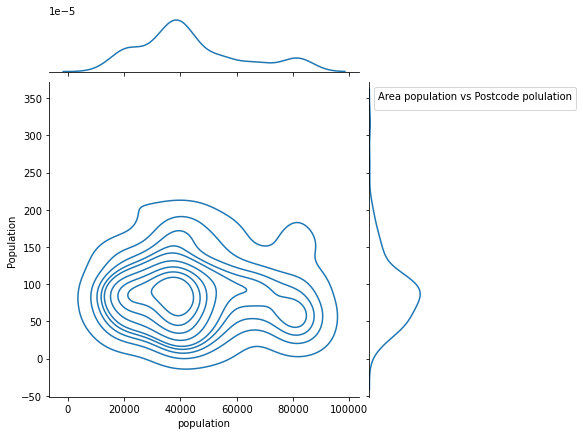

In [ ]:
sns.jointplot(x ='population', y ='Population', data = Data, kind ='kde')
plt.legend(title='Area population vs Postcode polulation')

No handles with labels found to put in legend.


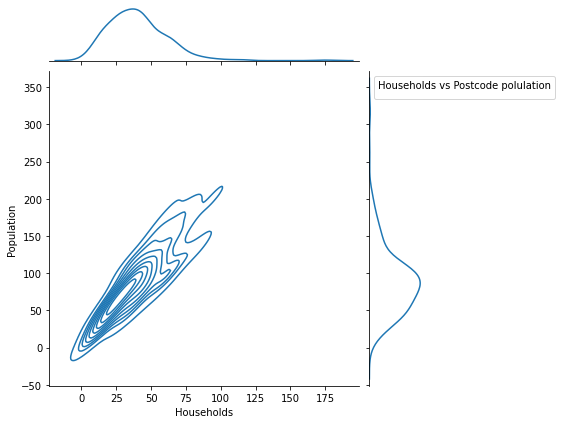

In [ ]:
sns.jointplot(x ='Households', y ='Population', data = Data, kind ='kde')
plt.legend(title='Households vs Postcode polulation')

### sq_PricePaid statistics -  Price per square foot

In [ ]:
Data['sq_PricePaid'].describe()

count      360.000000
mean      7652.174847
std       4550.769014
min        400.000000
25%       4850.281762
50%       6871.926230
75%       8936.170213
max      33333.333333
Name: sq_PricePaid, dtype: float64

No handles with labels found to put in legend.


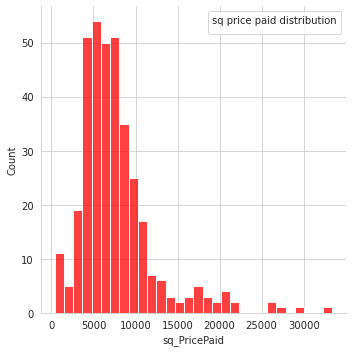

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['sq_PricePaid'], kde = False, color ='red', bins = 30)
plt.legend(title='sq price paid distribution')

No handles with labels found to put in legend.


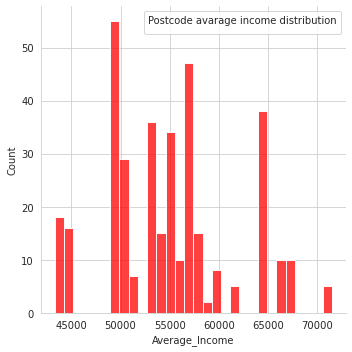

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Average_Income'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode avarage income distribution')

No handles with labels found to put in legend.


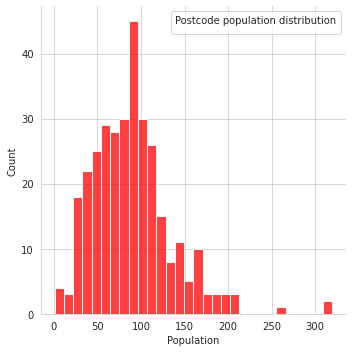

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Population'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode population distribution')

No handles with labels found to put in legend.


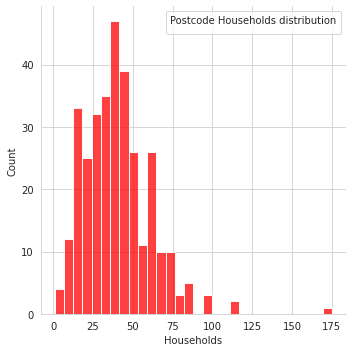

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['Households'], kde = False, color ='red', bins = 30)
plt.legend(title='Postcode Households distribution')

No handles with labels found to put in legend.


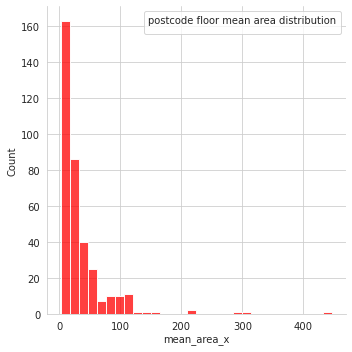

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['mean_area_x'], kde = False, color ='red', bins = 30)
plt.legend(title='postcode floor mean area distribution')

No handles with labels found to put in legend.


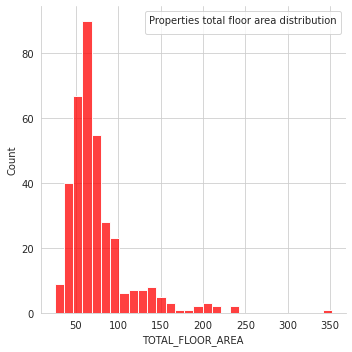

In [ ]:
sns.set_style('whitegrid')
sns.displot(Data['TOTAL_FLOOR_AREA'], kde = False, color ='red', bins = 30)
plt.legend(title='Properties total floor area distribution')

No handles with labels found to put in legend.


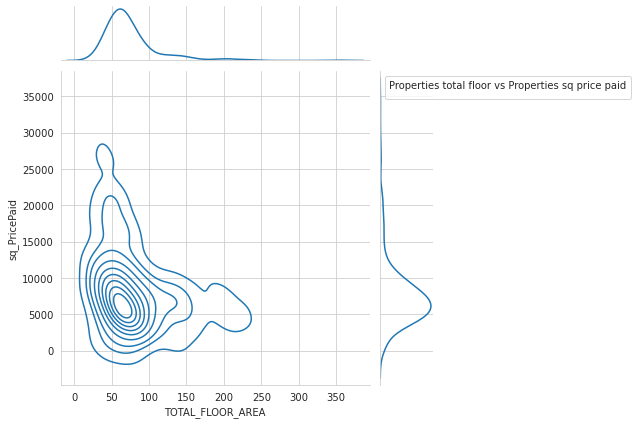

In [ ]:
sns.jointplot(x ='TOTAL_FLOOR_AREA', y ='sq_PricePaid', data = Data, kind ='kde')
plt.legend(title='Properties total floor vs Properties sq price paid')

### Categorical attribute binarization

In [ ]:

lbl = preprocessing.LabelEncoder()

catData = ['propertytype', 'oldnew', 'duration', 'categorytype', 'PROPERTY_TYPE', 'CONSTRUCTION_AGE_BAND', 'CURRENT_ENERGY_RATING', 'CONSTITUENCY_LABEL', 'crime_rating', 'ptal_x', 'flood_risk_x','restaurant_rating']
for att in catData:
    unique_classes = Data[att].unique()
    one_hot = pd.get_dummies(unique_classes, prefix=att,dummy_na=True, columns = [att])
    one_hot[att] = unique_classes
    Data = Data.merge(one_hot, on = [att], how='left')
    Data = Data.drop(columns = [att])
    #Data[att] = lbl.fit_transform(Data[att].astype(str))

### Define sq_price as target attribute 

In [ ]:
Data['sq_price'] = Data['sq_PricePaid']
Data.drop('sq_PricePaid',  axis = 1, inplace = True)
Data.drop('PricePaid', axis = 1, inplace = True)

### Attributes used for the model

In [ ]:
list(Data.columns)

['TOTAL_FLOOR_AREA',
 'Year_1_Value',
 'Year_2_Value',
 'Year_2_growth',
 'Year_3_Value',
 'Year_3_growth',
 'Year_4_Value',
 'Year_4_growth',
 'Year_5_Value',
 'Year_5_growth',
 'population',
 'crimes_last_12m',
 'crimes_per_thousand',
 'PublicOrder',
 'Burglary',
 'Robbery',
 'PossessionOfWeapons',
 'BicycleTheft',
 'AntiSocialBehaviour',
 'Violence',
 'Theft',
 'Shoplifting',
 'OtherCrime',
 'Drugs',
 'OtherTheft',
 'VehicleCrime',
 'CriminalDamage',
 'deprivation',
 'health',
 'age0_4',
 'age5_9',
 'age10_14',
 'age15_19',
 'age20_24',
 'age25_29',
 'age30_34',
 'age35_39',
 'age40_44',
 'age45_49',
 'age50_54',
 'age60_64',
 'age70_74',
 'age75_79',
 'age80_84',
 'age85_89',
 'proportion_with_degree',
 'vehicles_per_household',
 'commute_method_foot',
 'commute_method_bicycle',
 'commute_method_other',
 'commute_method_motorcycle',
 'commute_method_taxi',
 'commute_method_train',
 'commute_method_bus',
 'commute_method_underground_light_rail',
 'commute_method_car_driver',
 'commu

In [ ]:
# Split data
X, y = Data.iloc[:, :-1], Data.iloc[:, -1]

In [ ]:
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.2)

In [ ]:
Model tunning

In [ ]:

def objective(trial, X, y, kf):
    n_estimators = trial.suggest_int('n_estimators', 206, 512)
    learning_rate =trial.suggest_uniform('learning_rate', 0, 0.1) 
    #max_depth = trial.suggest_int('max_depth', 3, 10)
    min_split_loss = trial.suggest_uniform('min_split_loss', 0, 2.5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0, 10)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0, 10)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1)
    subsample = trial.suggest_uniform('subsample', 0.5, 1)
    eta = trial.suggest_uniform('eta', 0, 1)
    
    model = xg.XGBRegressor(n_estimators=n_estimators,
                          #max_depth=max_depth,
                          learning_rate=learning_rate,
                          min_split_loss=min_split_loss,
                          min_child_weight=min_child_weight,
                          reg_lambda=reg_lambda,
                          reg_alpha=reg_alpha,
                          colsample_bytree=colsample_bytree,
                          subsample=subsample,
                          eta=eta,
                          objective='reg:squarederror', 
                          booster='gbtree',
                          seed=42,
                          n_jobs=3)
    
    
    test_score = []
    
    step = 0
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        test_score.append(MAE(y_test, y_pred)/7652.174847*100)
        
        trial.report(np.mean(test_score), step)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        step+=1

    return np.mean(test_score)



kf = KFold(n_splits=4, shuffle=True, random_state=42)

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.SuccessiveHalvingPruner())

study.optimize(lambda trial: objective(trial, X, y, kf), timeout=30*60, n_jobs=1)

study.best_params 

NameError: name 'xxx' is not defined

Testing model

In [ ]:
model = XGBRegressor(objective='reg:squarederror', 
                     n_estimators= 432,
                     learning_rate= 0.023794434011489698,
                     min_split_loss= 1.0034482509971596,
                     min_child_weight= 1,
                     reg_lambda= 3.5516757286553884,
                     reg_alpha= 2.9113406779657796,
                     colsample_bytree= 0.9617305921239139,
                     subsample= 0.8029200013900768,
                     eta=0.6322135839655258)

xgb_r = model.fit(train_X, train_y)

#pred = xgb_r.predict(test_dmatrix)
pred = model.predict(test_X)

# RMSE Computation
mae =MAE(test_y, pred)
print("MAE : % f" %(mae))

#MAE :  2095.477237, 2012.491985

print("Mean: %f" %((mae/7652.174847)*100),"%")

#Mean: 27.384074 # 26.299608

MAE :  1383.501398
Mean: 18.079846 %


Cross validation

In [ ]:
# define model
# https://machinelearningmastery.com/xgboost-for-regression/

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f) %.3f' % (scores.mean(), scores.std(), ((scores.mean()/7652.174847)*100)),'%' )

Mean MAE: 1652.989 (354.416) 21.602 %


### Plot feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

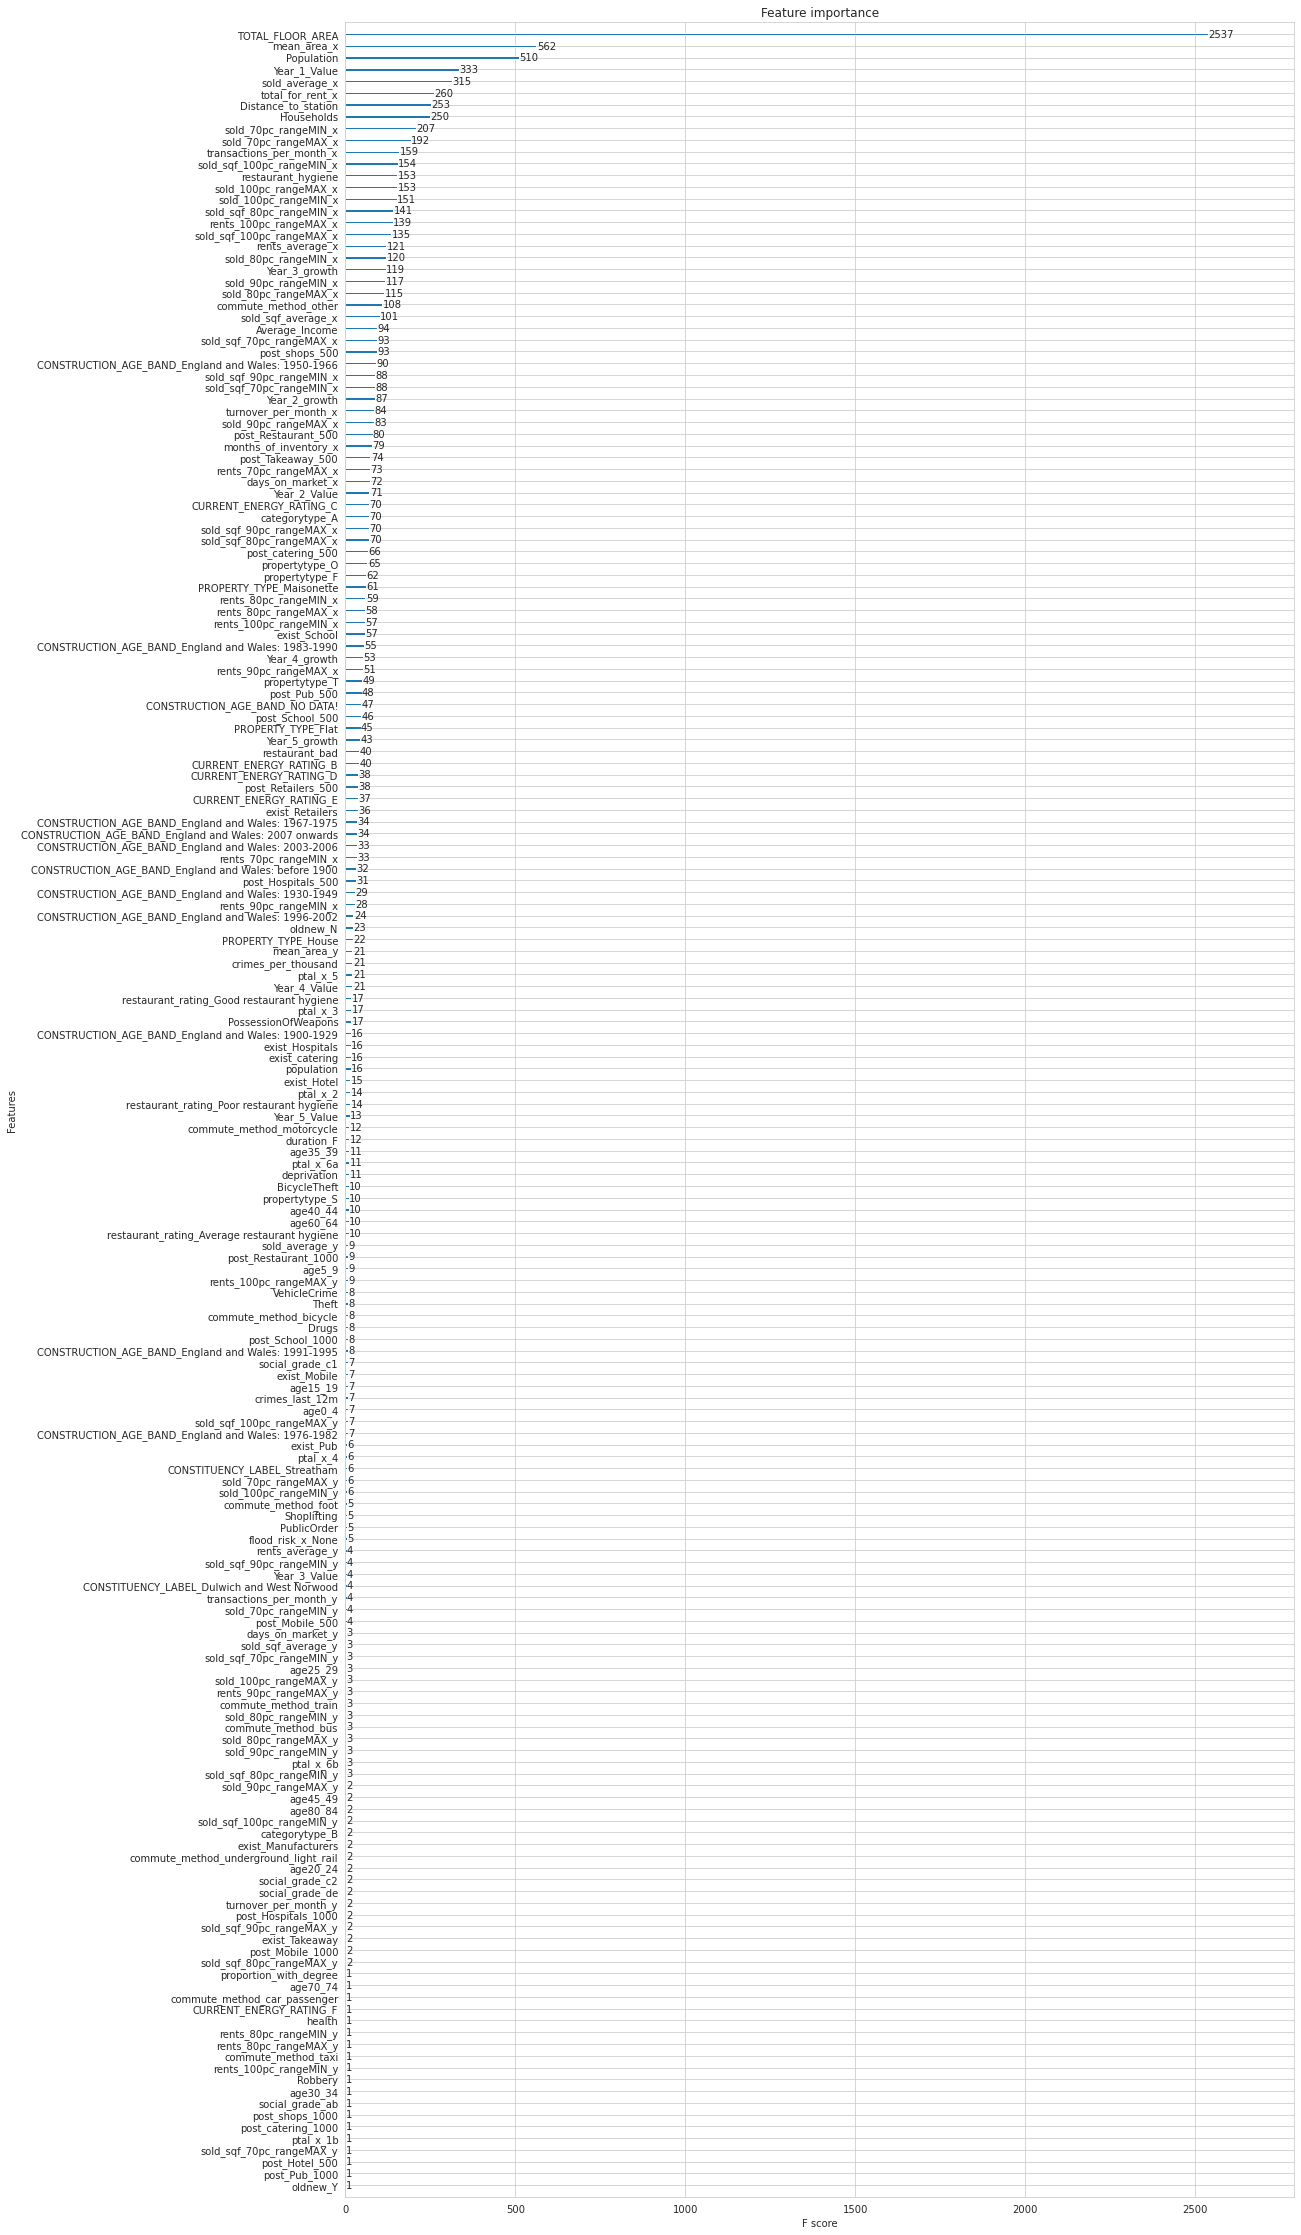

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17,40))

xg.plot_importance(xgb_r, ax)

/home/carlos/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'row'
  cset = contour_func(
No handles with labels found to put in legend.


Text(0.5, 32.99999999999995, 'real sq price')

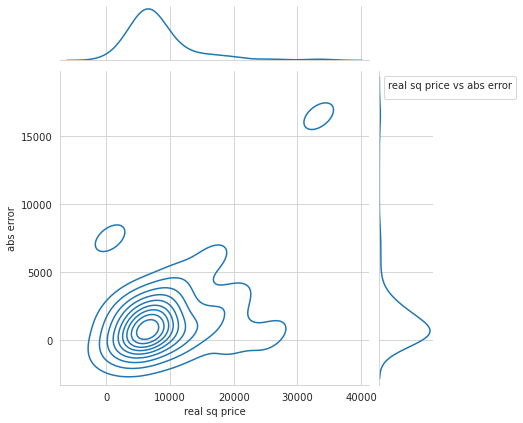

In [ ]:
h=sns.jointplot(x = test_y, y = np.abs(test_y-pred), kind ='kde', row="day")
plt.legend(title='real sq price vs abs error')
h.ax_joint.set_ylabel('abs error')
h.ax_joint.set_xlabel('real sq price')

No handles with labels found to put in legend.


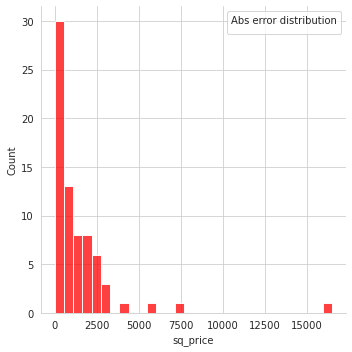

In [ ]:
sns.set_style('whitegrid')
h=sns.displot(np.abs(test_y-pred), kde = False, color ='red', bins = 30)
plt.legend(title='Abs error distribution')